## Environment Setup
Install dependent packages and define helper functions.

We assume you have already have pytorch, numpy and tqdm installed. For reproducibility, we depend on the following packages:

[Diffusers](https://huggingface.co/docs/diffusers/en/index) version 0.12.1, you can install it by running following block if
you haven't already.

In [1]:
!pip install diffusers==0.12.1
!pip install huggingface_hub==0.20.3
!pip install transformers==4.28.1
!pip uninstall accelerate peft jax jaxlib -y

  Using cached diffusers-0.12.1-py3-none-any.whl.metadata (32 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached diffusers-0.12.1-py3-none-any.whl (604 kB)
Using cached huggingface_hub-0.29.3-py3-none-any.whl (468 kB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached huggingface_hub-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.20.3-py3-none-any.whl (330 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.29.3
    Uninstalling huggingface-hub-0.29.3:
      Successfully uninstalled huggingface-hub-0.29.3

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --u

Here we define some helper functions to display the generated samples in notebook (display_sampl()) and
a "random" noise generator (random_tensor). There are also the reproducibility code, you must run this before
you submit your notebook.

In [2]:
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
import tqdm
import torch
import PIL.Image
import numpy as np

torch.backends.cuda.matmul.allow_tf32 = False

torch.backends.cudnn.allow_tf32 = False

def display_sample(sample, i):
    """
    Display the processed image sample.
    Args:
        sample (torch.Tensor): The processed image sample.
        i (int): The step number.
    """
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

def randn_tensor(shape, generator=None, device=None, dtype=None, layout=None):
    rand_device = device

    layout = layout or torch.strided
    device = device or torch.device("cpu")

    return torch.randn(
        shape,
        generator=generator,
        device=rand_device,
        dtype=dtype,
        layout=layout,
    ).to(device)

2025-03-20 21:04:33.915158: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 21:04:33.931126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 21:04:33.950433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 21:04:33.956075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 21:04:33.970061: I tensorflow/core/platform/cpu_feature_guar

Here is the way to download pre-trained diffusion model from HuggingFace, you can use similar code to download different
diffusion models by exploring their [hub](https://huggingface.co/models).

In [3]:
torch.manual_seed(0)

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)
model.to("cuda")

noisy_sample = torch.randn(
    1,
    model.config.in_channels,
    model.config.sample_size,
    model.config.sample_size,
)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/opt/conda/lib/python3.11/site-packages/diffusers/models/modeling_utils.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

In [4]:
class CustomDDPMScheduler_q:
    def __init__(
        self,
        num_train_timesteps,
        beta_start,
        beta_end,
    ):
        # This the basic setting for a 1000 tiemsteps Diffusion Model, and we have
        # defined the betas and alphas and alphas_cumprod for you.
        self.num_inference_steps = 1000
        self.timesteps = torch.from_numpy(
            np.arange(0, num_train_timesteps)[::-1].copy()
        )

        self.betas = torch.linspace(
            beta_start, beta_end, num_train_timesteps
        ).to("cuda")
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = (1 - self.betas).cumprod(dim=0)

    def sqrt_alpha_prod(self, timesteps, original_samples):
        sqrt_alpha_prod = torch.sqrt(
            self.alphas_cumprod[timesteps]
        )
        return sqrt_alpha_prod

    def sqrt_one_minus_alpha_prod(self, timesteps, original_samples):
        sqrt_one_minus_alpha_prod = torch.sqrt(
           1 - self.alphas_cumprod[timesteps]
        )

        return sqrt_one_minus_alpha_prod

    def add_noise(
        self,
        original_samples,
        noise,
        timesteps,
    ):
        # Calculate the square roots of alpha and (1 - alpha) cumulative products
        sqrt_alpha_prod = self.sqrt_alpha_prod(timesteps, original_samples)
        sqrt_one_minus_alpha_prod = self.sqrt_one_minus_alpha_prod(timesteps, original_samples)

        # Add noise to the samples based on the calculated square roots
        noisy_samples =  sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples 

In [5]:
# p sample
scheduler = CustomDDPMScheduler_q(1000, 0.0001, 0.02)

# NOTE: Here you must use the npy file which you can find with this notebook!
sample = np.load("tensor.npy")
noisy_sample = torch.tensor(sample)

# Here is how you use the custom DDPMScheduler to destory image into the Noise:
noise = torch.randn(
    noisy_sample.shape,
    dtype=torch.float32,
).to('cuda')
noisy_sample = noisy_sample.to("cuda")
noisy_sample = scheduler.add_noise(
    noisy_sample, noise, timesteps=torch.tensor(999, dtype=torch.int32)
)
np.save("noisy_sample.npy", noisy_sample.cpu().numpy())
noisy_sample = noisy_sample.to("cuda")
sample = noisy_sample.clone()

In [6]:
class CustomDDPMScheduler_p:
    def __init__(
        self,
        num_train_timesteps,
        beta_start,
        beta_end,
    ):
        # This is the same as the previous CustomDDPMScheduler_q
        self.num_inference_steps = 1000
        self.timesteps = torch.from_numpy(
            np.arange(0, num_train_timesteps)[::-1].copy()
        )

        self.betas = torch.linspace(
            beta_start, beta_end, num_train_timesteps
        ).to("cuda")
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = (1 - self.betas).cumprod(dim=0)

    def get_variance(self, t):
        # Calculate the variance
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)
        variance = (1- alpha_prod_t_prev)/(1- alpha_prod_t) * self.betas[t]

        # Stabilizing the variance
        return torch.clamp(variance, min=1e-20)

    def compute_alphas_betas(self, t):
        # Compute alphas and betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        return alpha_prod_t, alpha_prod_t_prev, beta_prod_t, beta_prod_t_prev

    def predict_original_sample(self, model_output, sample, beta_prod_t, alpha_prod_t):
        # Calculate the predicted original sample, i.e., "predicted x_0"
        pred_original_sample = (sample - torch.sqrt(1- alpha_prod_t) * model_output) / torch.sqrt(alpha_prod_t)
        # Clip "predicted x_0"
        return torch.clamp(pred_original_sample, -1, 1)

    def compute_coeffs(self, t, beta_prod_t, alpha_prod_t, alpha_prod_t_prev):
        # Compute coefficients for pred_original_sample x_0 and the current sample x_t
        pred_original_sample_coeff = (torch.sqrt(alpha_prod_t_prev) * self.betas[t]) / (1- alpha_prod_t)
        current_sample_coeff = (torch.sqrt(self.alphas[t]) * (1 - alpha_prod_t_prev)) / (1- alpha_prod_t)
        return pred_original_sample_coeff, current_sample_coeff

    def predict_previous_sample(self, pred_original_sample_coeff, current_sample_coeff, pred_original_sample, sample):
        # Calculate the predicted previous sample µ_t
        mu_t = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
        return mu_t

    def step(self, model_output, timestep, sample):
        t = timestep
        alpha_prod_t, alpha_prod_t_prev, beta_prod_t, beta_prod_t_prev = self.compute_alphas_betas(t)
        pred_original_sample = self.predict_original_sample(model_output, sample, beta_prod_t, alpha_prod_t)
        pred_original_sample_coeff, current_sample_coeff = self.compute_coeffs(t, beta_prod_t, alpha_prod_t, alpha_prod_t_prev)
        pred_prev_sample = self.predict_previous_sample(pred_original_sample_coeff, current_sample_coeff, pred_original_sample, sample)

        # Add noise (as in the original implementation)
        variance = 0
        if t > 0:
            device = model_output.device
            variance_noise = randn_tensor(
                model_output.shape,
                generator=None,
                device=device,
                dtype=model_output.dtype,
            )
            variance = (self.get_variance(t) ** 0.5) * variance_noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

### Here, I show you have to use Diffusers' API to reconstruct a image from noise.

/opt/conda/lib/python3.11/site-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
 10%|▉         | 99/1000 [00:03<00:30, 29.63it/s]

'Image at step 100'

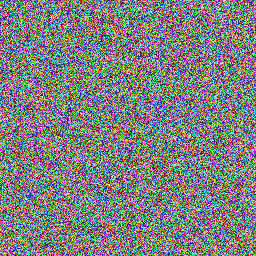

 20%|█▉        | 199/1000 [00:07<00:27, 29.66it/s]

'Image at step 200'

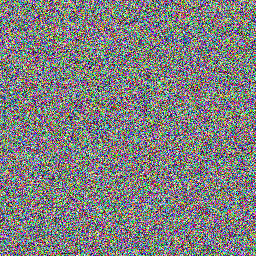

 30%|██▉       | 299/1000 [00:10<00:23, 29.57it/s]

'Image at step 300'

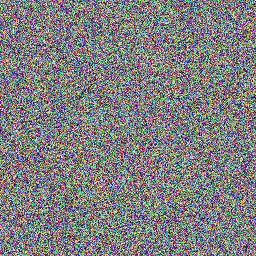

 40%|███▉      | 398/1000 [00:13<00:20, 29.61it/s]

'Image at step 400'

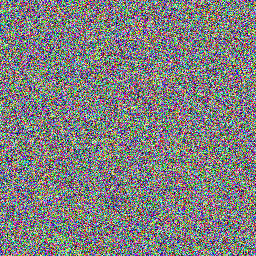

 50%|████▉     | 498/1000 [00:17<00:16, 29.62it/s]

'Image at step 500'

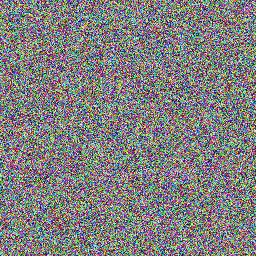

 60%|█████▉    | 599/1000 [00:20<00:13, 29.60it/s]

'Image at step 600'

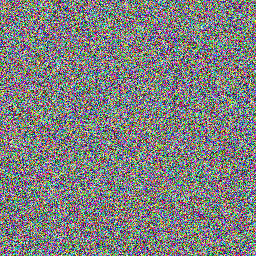

 70%|██████▉   | 699/1000 [00:24<00:10, 29.59it/s]

'Image at step 700'

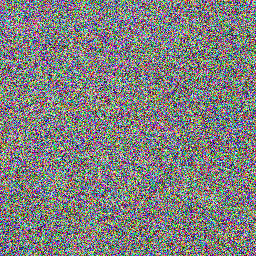

 80%|███████▉  | 799/1000 [00:27<00:06, 29.60it/s]

'Image at step 800'

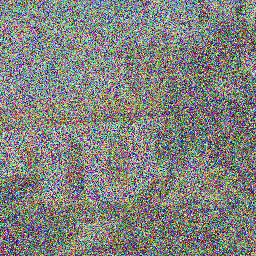

 90%|████████▉ | 898/1000 [00:30<00:03, 29.57it/s]

'Image at step 900'

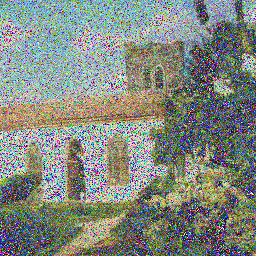

100%|█████████▉| 997/1000 [00:34<00:00, 29.56it/s]

'Image at step 1000'

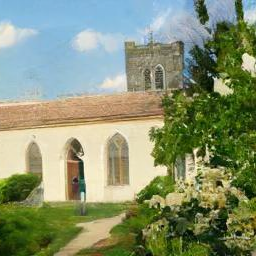

100%|██████████| 1000/1000 [00:34<00:00, 29.01it/s]


In [7]:
torch.manual_seed(0)
sample = torch.tensor(np.load("noisy_sample.npy")).to("cuda")
diffusers_scheduler = DDPMScheduler.from_config(repo_id)
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    #predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # compute less noisy image and set x_t -> x_t-1
    sample = diffusers_scheduler.step(residual, t, sample).prev_sample

    # optionally look at image
    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1)

diffusers_sample = sample.cpu().clone()

### Here is how I use my custom Scheduler to reconstruct the image.

 10%|▉         | 98/1000 [00:03<00:30, 29.51it/s]

'Image at step 100'

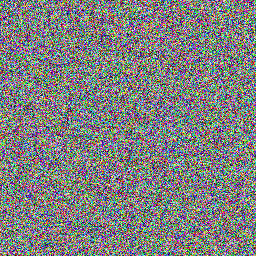

 20%|█▉        | 197/1000 [00:06<00:27, 29.59it/s]

'Image at step 200'

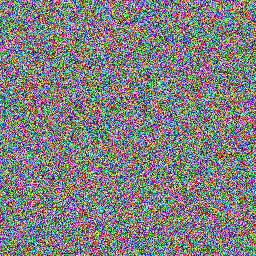

 30%|██▉       | 297/1000 [00:10<00:23, 29.48it/s]

'Image at step 300'

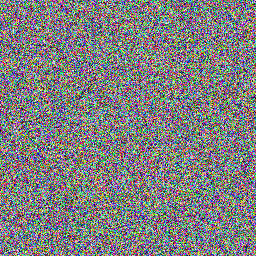

 40%|███▉      | 397/1000 [00:13<00:20, 29.56it/s]

'Image at step 400'

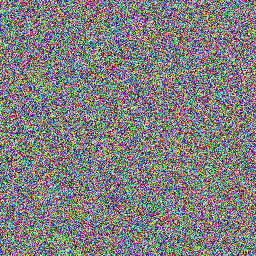

 50%|████▉     | 498/1000 [00:17<00:16, 29.59it/s]

'Image at step 500'

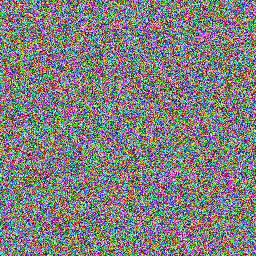

 60%|█████▉    | 598/1000 [00:20<00:13, 29.67it/s]

'Image at step 600'

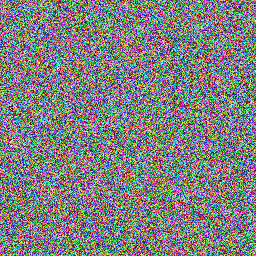

 70%|██████▉   | 699/1000 [00:23<00:10, 29.59it/s]

'Image at step 700'

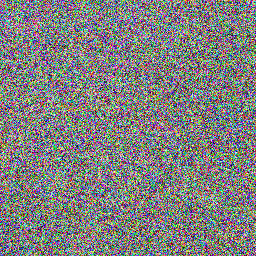

 80%|███████▉  | 799/1000 [00:27<00:06, 29.61it/s]

'Image at step 800'

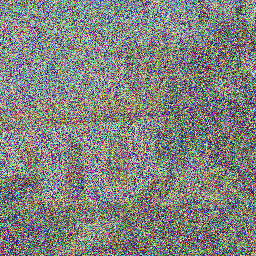

 90%|████████▉ | 898/1000 [00:30<00:03, 29.56it/s]

'Image at step 900'

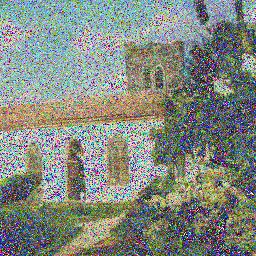

100%|█████████▉| 998/1000 [00:34<00:00, 29.58it/s]

'Image at step 1000'

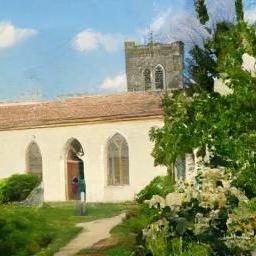

100%|██████████| 1000/1000 [00:34<00:00, 29.29it/s]


In [8]:
# q sample
torch.manual_seed(0)
scheduler = CustomDDPMScheduler_p(1000, 0.0001, 0.02)
sample = torch.tensor(np.load("noisy_sample.npy")).to("cuda")
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample)

    # 3. optionally look at image
    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1)

our_sample = sample.cpu().clone()

### Validate Your Results

Use this section to verify whether your generated results align closely with diffusers'.

In [9]:
try:
    torch.testing.assert_close(our_sample, diffusers_sample, rtol=1e-3, atol=1e-3)
except AssertionError:
    print("The two tensors are not close to each other. Try rerunning the code or find the bug.")
else:
    print("Congratulations! You have passed the test.")

Congratulations! You have passed the test.
